Overview:
In this project, Apply segmentation techniques to a set of brain imaging data to identify and analyze different brain regions. This project aims to deepen your understanding of neuroimaging analysis and improve your skills in image processing and machine learning applications in medical imaging.

 Data Access:
The data for this project can be accessed via the following link:

https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2

Dataset: Task01_Braintumour.rar

Objectives:
1. Data Preparation: Download the MRI data from the provided link.

2. Segmentation Task: Implement a segmentation method to segment the brain images. You may choose advanced methods such as machine learning models (e.g., U-Net, V-Net).

3. Visualization: Visualize the segmentation results. Provide at least three images showing the original images with their corresponding segmentation maps.



In [ ]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow as tf
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

In [ ]:
from keras.utils import Sequence

# Data Loading

In [ ]:
# Define the path to the dataset directory
data_directory = "/kaggle/input/inputdataset/Task01_BrainTumour"

# Get all sample IDs from the directory using listdir()
sample_ids = os.listdir(data_directory + '/imagesTr')
print("Number of samples:", len(sample_ids))

Number of samples: 20


In [ ]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(sample_ids, test_size=0.2, random_state=42)

# Print data distribution
print(f"Train length: {len(samples_train)}")

Train length: 16


In [ ]:
# Define selected slices range
VOLUME_START_AT = 0
VOLUME_SLICES = 155

# Data Loader

In [ ]:
# Image sizes
RESIZED_IMG_SIZE = 128

class CustomDataGenerator(Sequence):
    'Custom Data Generator for Keras'
    def __init__(self, patient_ids, dimensions=(RESIZED_IMG_SIZE, RESIZED_IMG_SIZE), batch_size=1, num_channels=4, shuffle=True):
        'Initialization'
        self.dimensions = dimensions  # Resized image dimensions (128 x 128)
        self.batch_size = batch_size  # Number of images to load each time
        self.patient_ids = patient_ids  # List of patient IDs
        self.num_channels = num_channels  # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle  # Indicates if data is shuffled for each epoch
        self.on_epoch_end()  # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.patient_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of patient IDs
        batch_patient_ids = [self.patient_ids[k] for k in indexes]

        # Load & Generate data
        X, y = self.__generate_data(batch_patient_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.patient_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __generate_data(self, batch_patient_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dimensions, self.num_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))

        # Generate data
        for idx, patient_id in enumerate(batch_patient_ids):
            # Get paths for each MRI modality and the segmentation
            img_path = os.path.join(data_directory, 'imagesTr', patient_id)
            seg_path = os.path.join(data_directory, 'labelsTr', patient_id)

            # Load MRI data and segmentation
            mri_data = nib.load(img_path).get_fdata()
            seg_data = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                # Resize MRI data
                X[j + VOLUME_SLICES * idx, :, :, :] = cv2.resize(mri_data[:, :, j + VOLUME_START_AT], self.dimensions)

                # Copy segmentation data
                y[j + VOLUME_SLICES * idx] = seg_data[:, :, j + VOLUME_START_AT]

        # Process labels / segmentations
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, self.dimensions)

        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X / np.max(X), Y

In [ ]:
# Create an instance of the custom data generator
custom_training_generator = CustomDataGenerator(samples_train)

# UNet

In [ ]:
def U_Net(inputs, ker_init, dropout):
    'model definition'
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)

    up1 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=2)(conv2))
    merge1 = concatenate([conv1, up1], axis=3)
    conv3 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge1)
    conv3 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)

    conv4 = Conv2D(4, 1, activation='relu')(conv3)
    'model definition ended'
    return Model(inputs=inputs, outputs=conv4)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
#     print('loss called')
    class_num = 4
    for i in range(class_num):
        y_true_f = tf.keras.backend.reshape(y_true[:,:,:,i], (-1,))
        y_pred_f = tf.keras.backend.reshape(y_pred[:,:,:,i], (-1,))

        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#     print('loss ended')
    return total_loss

In [ ]:
# Define input data shape
input_layer = Input((RESIZED_IMG_SIZE, RESIZED_IMG_SIZE, 4))

# Build and compile the model
model = U_Net(input_layer, 'he_normal',0.2)

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef] )

In [ ]:
model.fit(custom_training_generator,epochs=10)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 475ms/step - accuracy: 0.7358 - dice_coef: 0.0679 - loss: nan - mean_io_u_1: 0.1389
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 508ms/step - accuracy: 0.9512 - dice_coef: 0.1826 - loss: nan - mean_io_u_1: 0.1384
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 522ms/step - accuracy: 0.9718 - dice_coef: 0.2101 - loss: nan - mean_io_u_1: 0.1413
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 517ms/step - accuracy: 0.9816 - dice_coef: 0.2131 - loss: nan - mean_io_u_1: 0.1487
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 516ms/step - accuracy: 0.9823 - dice_coef: 0.2275 - loss: nan - mean_io_u_1: 0.1486
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 521ms/step - accuracy: 0.9800 - dice_coef: 0.2482 - loss: nan - mean_io_u_1: 0.1375
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 521ms/step - accuracy: 0.9851 - dice_coef: 0.2541 - loss: nan - mean_io_u_1: 0.1376
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 525ms/step - accuracy: 0.9822 - dice_coef: 0.2609 - loss: nan - mean_io_u_1:

In [ ]:
# Define input data shape
input_layer = Input((RESIZED_IMG_SIZE, RESIZED_IMG_SIZE, 4))

# Build and compile the model
model2 = U_Net(input_layer, 'he_normal',0.2)

model2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef] )

In [ ]:
model2.fit(custom_training_generator,epochs=10)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 517ms/step - accuracy: 0.9704 - dice_coef: 0.1409 - loss: nan - mean_io_u_4: 0.1563
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 524ms/step - accuracy: 0.9737 - dice_coef: 0.1513 - loss: nan - mean_io_u_4: 0.1556
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 515ms/step - accuracy: 0.9746 - dice_coef: 0.1513 - loss: nan - mean_io_u_4: 0.1550
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 517ms/step - accuracy: 0.9774 - dice_coef: 0.1581 - loss: nan - mean_io_u_4: 0.1545
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 522ms/step - accuracy: 0.9770 - dice_coef: 0.1590 - loss: nan - mean_io_u_4: 0.1544
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 523ms/step - accuracy: 0.9772 - dice_coef: 0.1706 - loss: nan - mean_io_u_4: 0.1543
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 518ms/step - accuracy: 0.9818 - dice_coef: 0.1670 - loss: nan - mean_io_u_4: 0.1541
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 516ms/step - accuracy: 0.9771 - dice_coef: 0.1667 - loss: nan - mean_io_u_4:

# Model predictions

In [ ]:
def predict(sample_path):
    flair_path = sample_path

    # Extract the data from these paths
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, RESIZED_IMG_SIZE, RESIZED_IMG_SIZE, 4))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,:] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (RESIZED_IMG_SIZE,RESIZED_IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model2.predict(X/np.max(X), verbose=1)

In [ ]:
pred = predict(data_directory+'/imagesTr/BRATS_003.nii')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


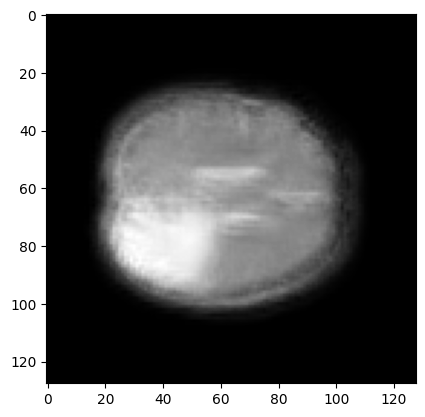

In [ ]:
plt.imshow(pred[100,:,:,0], cmap='gray')

In [ ]:
train_names = ['BRATS_020.nii','BRATS_019.nii','BRATS_018.nii','BRATS_017.nii']

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


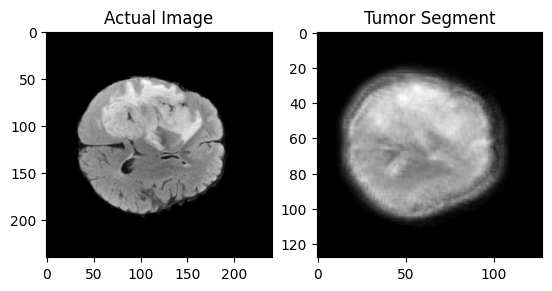

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


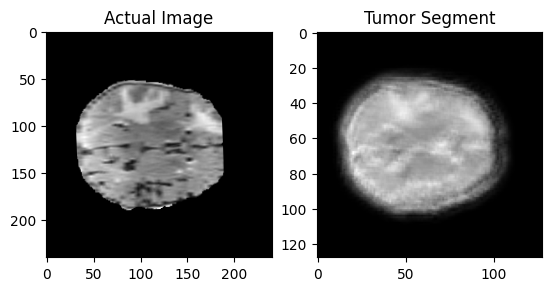

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


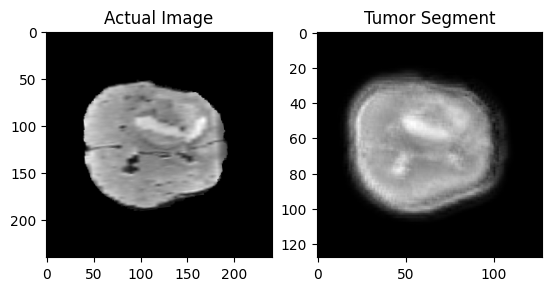

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


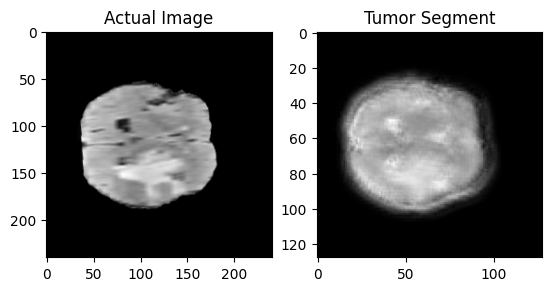

In [ ]:
# Printing the segmentation images for the training set
for name in train_names:
    current_img = nib.load(data_directory+'/imagesTr/'+name).get_fdata()
    current_prediction = predict(data_directory+'/imagesTr/'+name)
    plt.subplot(1,2,1)
    plt.imshow(current_img[:,:,80,0], cmap='gray')
    plt.title('Actual Image')
    plt.subplot(1,2,2)
    plt.imshow(current_prediction[80,:,:,0], cmap='gray')
    plt.title('Tumor Segment')
    plt.show()

In [ ]:
test_names = ['BRATS_485.nii','BRATS_486.nii','BRATS_487.nii','BRATS_488.nii']

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


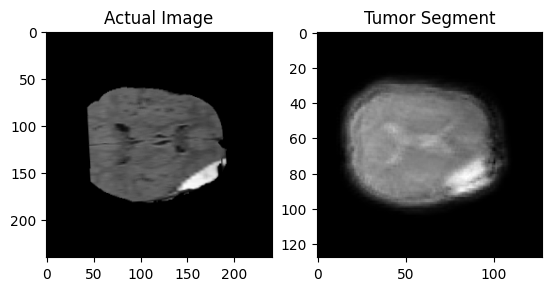

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


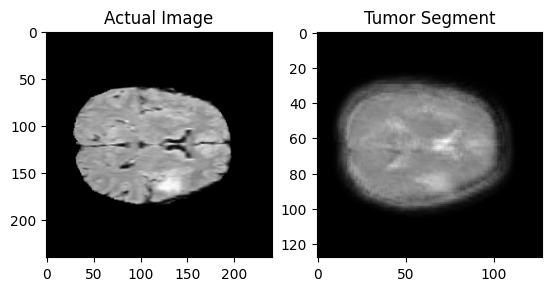

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


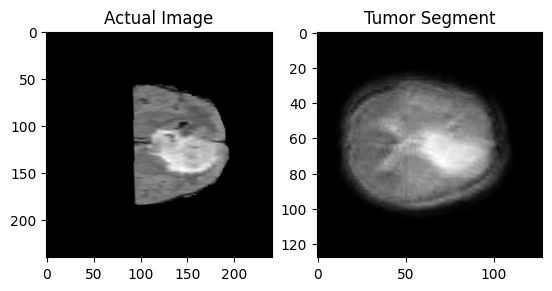

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


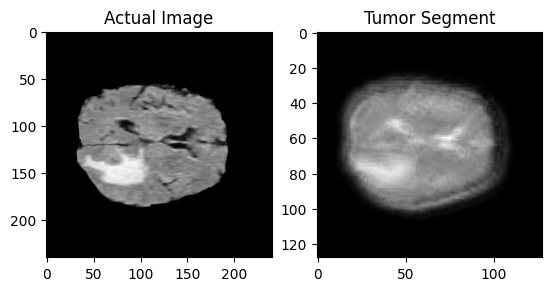

In [ ]:
# Printing the segmentation images for testing dataset
for name in test_names:
    current_img = nib.load(data_directory+'/imagesTs/'+name).get_fdata()
    current_prediction = predict(data_directory+'/imagesTs/'+name)
    plt.subplot(1,2,1)
    plt.imshow(current_img[:,:,80,0], cmap='gray')
    plt.title('Actual Image')
    plt.subplot(1,2,2)
    plt.imshow(current_prediction[80,:,:,0], cmap='gray')
    plt.title('Tumor Segment')
    plt.show()